# 단순 Seasonal ARIMA 모형

## 확률 과정을 이루는 계절 추세

seasonal 데이터인경우 봄,여름,가을,겨울의 데이터들만 따로 뽑아서 모형을 만든다 
그래서 추세를 확인후 예측한다. 봄의 데이터를 뽑아서 쓰면 데이터들의 계수가 같거나 비슷하다 
그렇게 되면 봄,여름,가을, 겨울의 데이터 모형들은 bias(절편,intercept)이 다르고 계수가 차이가 잘 안나는 모형이 만들어진다
그렇게 만들어진 모델이 MA 가 될수 있고 AR 이 될수도 있다 
seasonal ARIMA 모형은 한번 차분하면 seasonal ARMA 모형이 된다 

대기중 이산화탄소 농도에 대한 시계열 자료를 보자.

In [1]:
data = sm.datasets.get_rdataset("co2")
df = data.data

def yearfraction2datetime(yearfraction, startyear=0):
    import datetime, dateutil
    year = int(yearfraction) + startyear
    month = int(round(12 * (yearfraction - year)))
    delta = dateutil.relativedelta.relativedelta(months=month)
    date = datetime.datetime(year, 1, 1) + delta
    return date

df["datetime"] = df.time.map(yearfraction2datetime)
df.tail()

,time,co2,datetime
463,1997.583333,362.57,1997-08-01
464,1997.666667,360.24,1997-09-01
465,1997.750000,360.83,1997-10-01
466,1997.833333,362.49,1997-11-01
467,1997.916667,364.34,1997-12-01


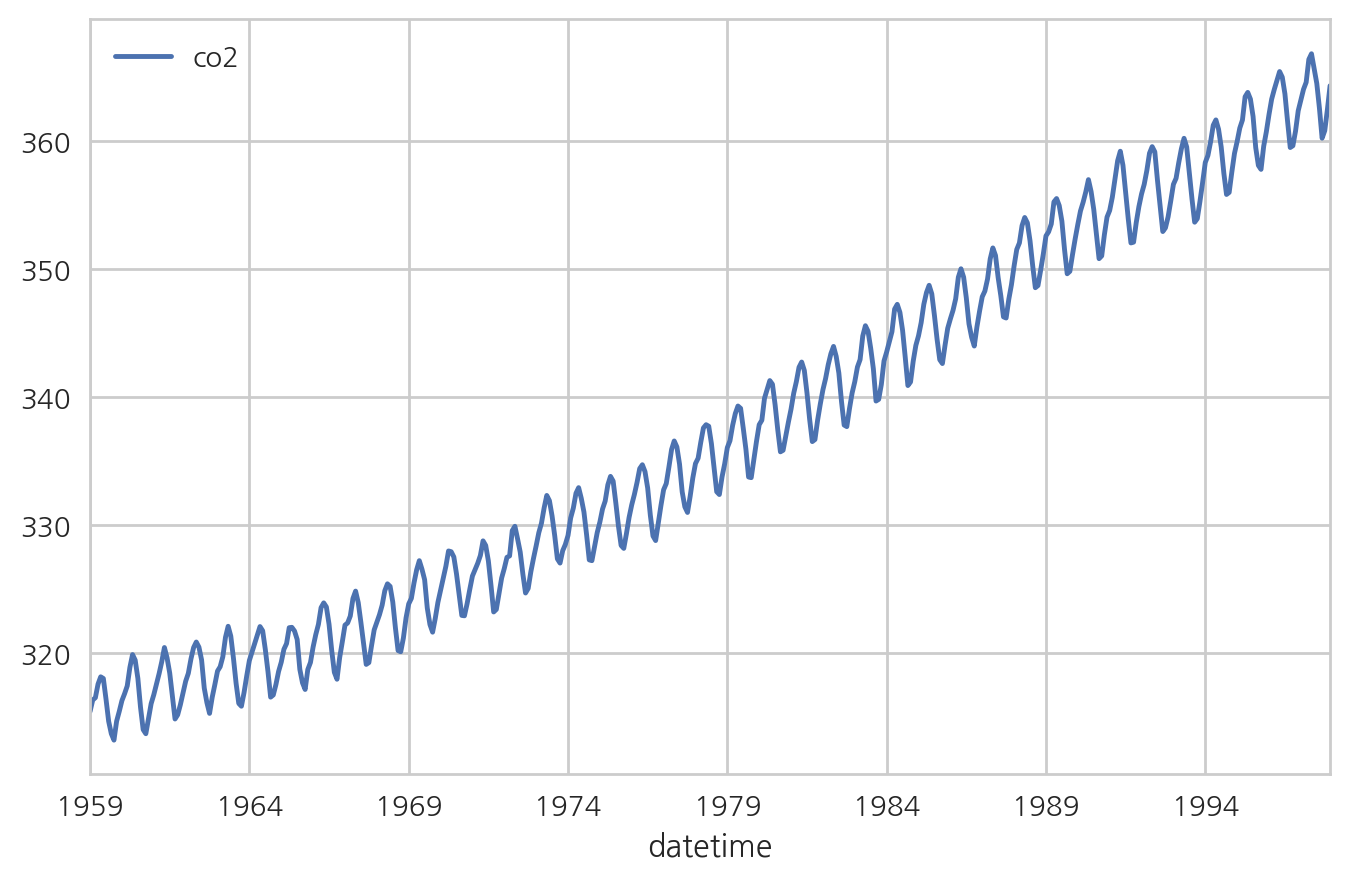

In [2]:
df.plot(x="datetime", y="co2")
plt.show()

우선 차분을 통해 정상 시계열로 만든다.

In [4]:
df["y"] = df["co2"].diff()
df2 = df.iloc[1:, :]

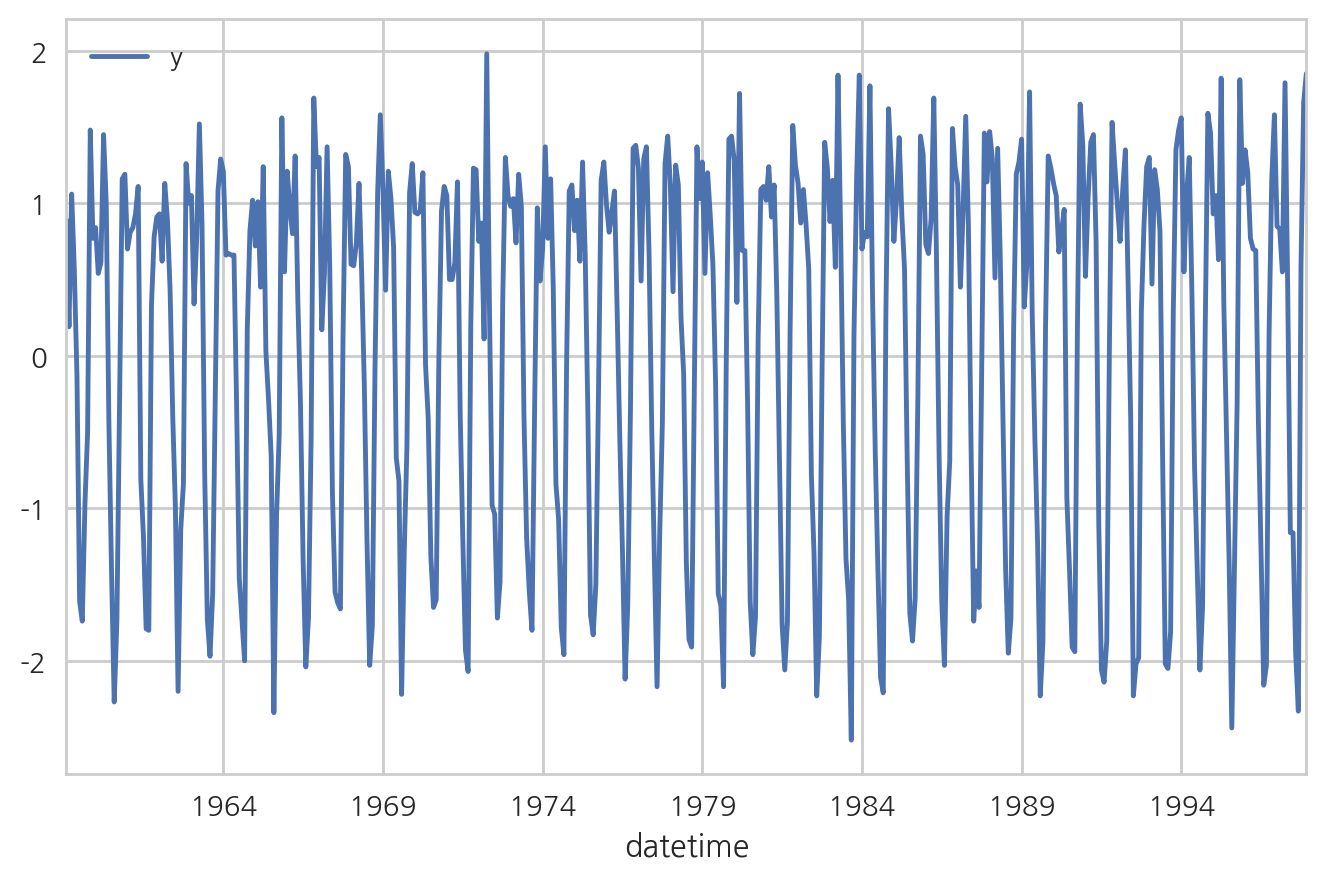

In [5]:
df2.plot(x="datetime", y="y")
plt.show()

이 시계열 자체는 낮은 차수의 ARMA 모형으로 모형화하기 힘든 복잡한 시계열이다.

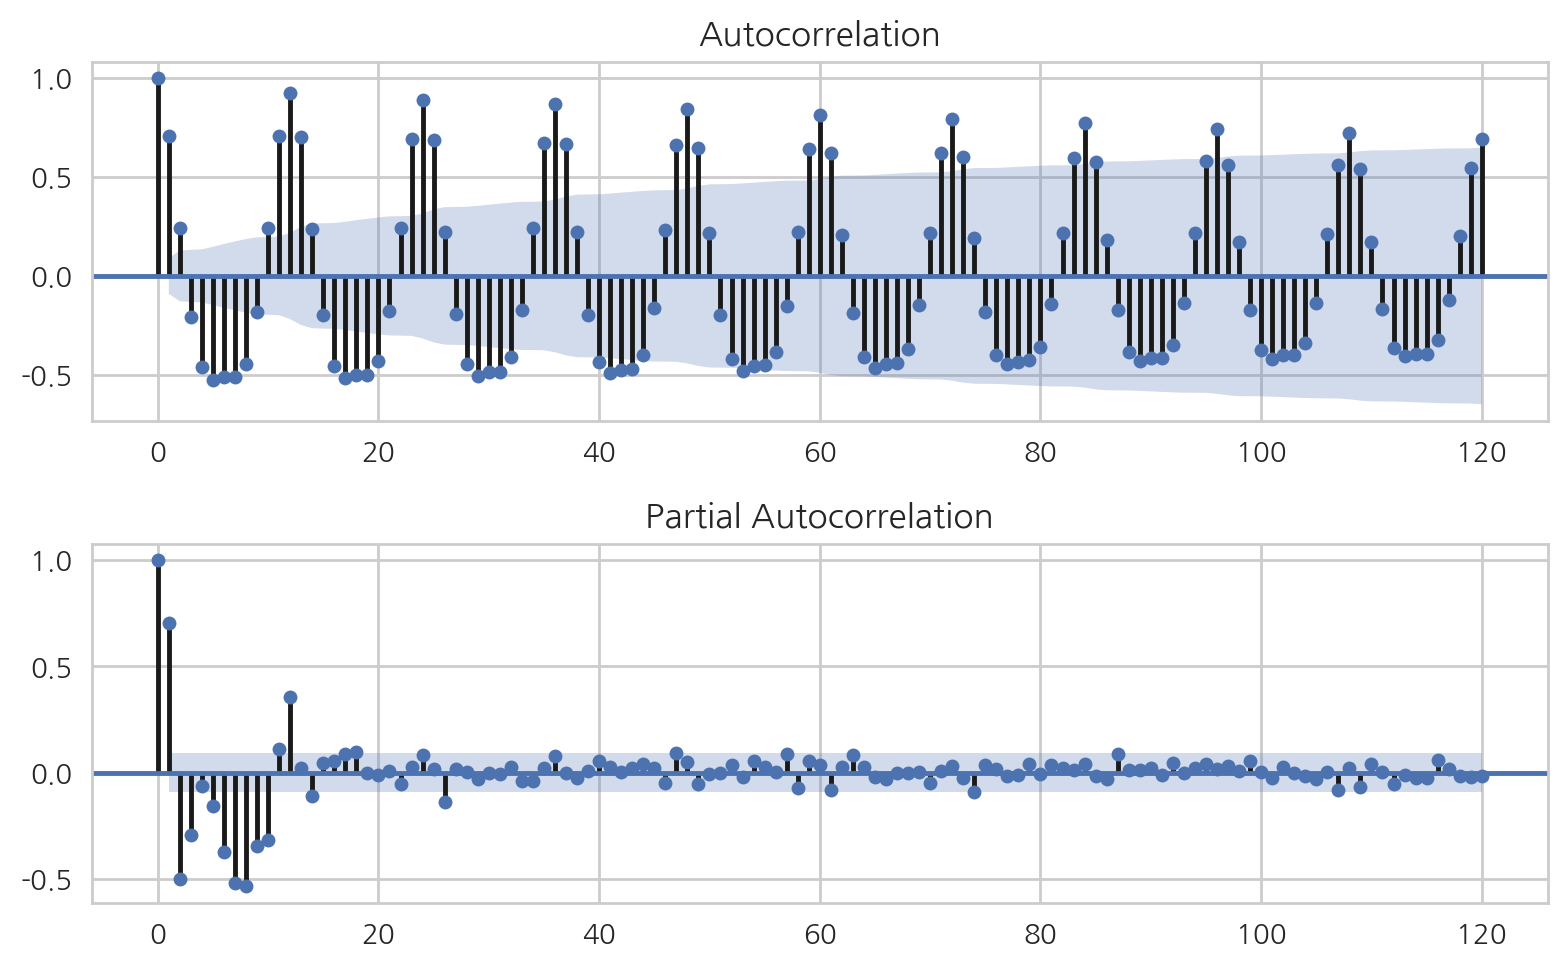

In [7]:
ax1 = plt.subplot(211); sm.graphics.tsa.plot_acf(df2["y"], lags=120, ax=ax1)
ax2 = plt.subplot(212); sm.graphics.tsa.plot_pacf(df2["y"], lags=120, ax=ax2)
plt.tight_layout()
plt.show()

하지만 여기에서 특정한 달, 예를 들어 1월달의 자료만 떼어서 보면 다음과 같다.

In [20]:
df.loc[:, "month"] = df.datetime.dt.month.values
df.tail()

,time,co2,datetime,y,month
463,1997.583333,362.57,1997-08-01,-1.95,8
464,1997.666667,360.24,1997-09-01,-2.33,9
465,1997.750000,360.83,1997-10-01,0.59,10
466,1997.833333,362.49,1997-11-01,1.66,11
467,1997.916667,364.34,1997-12-01,1.85,12


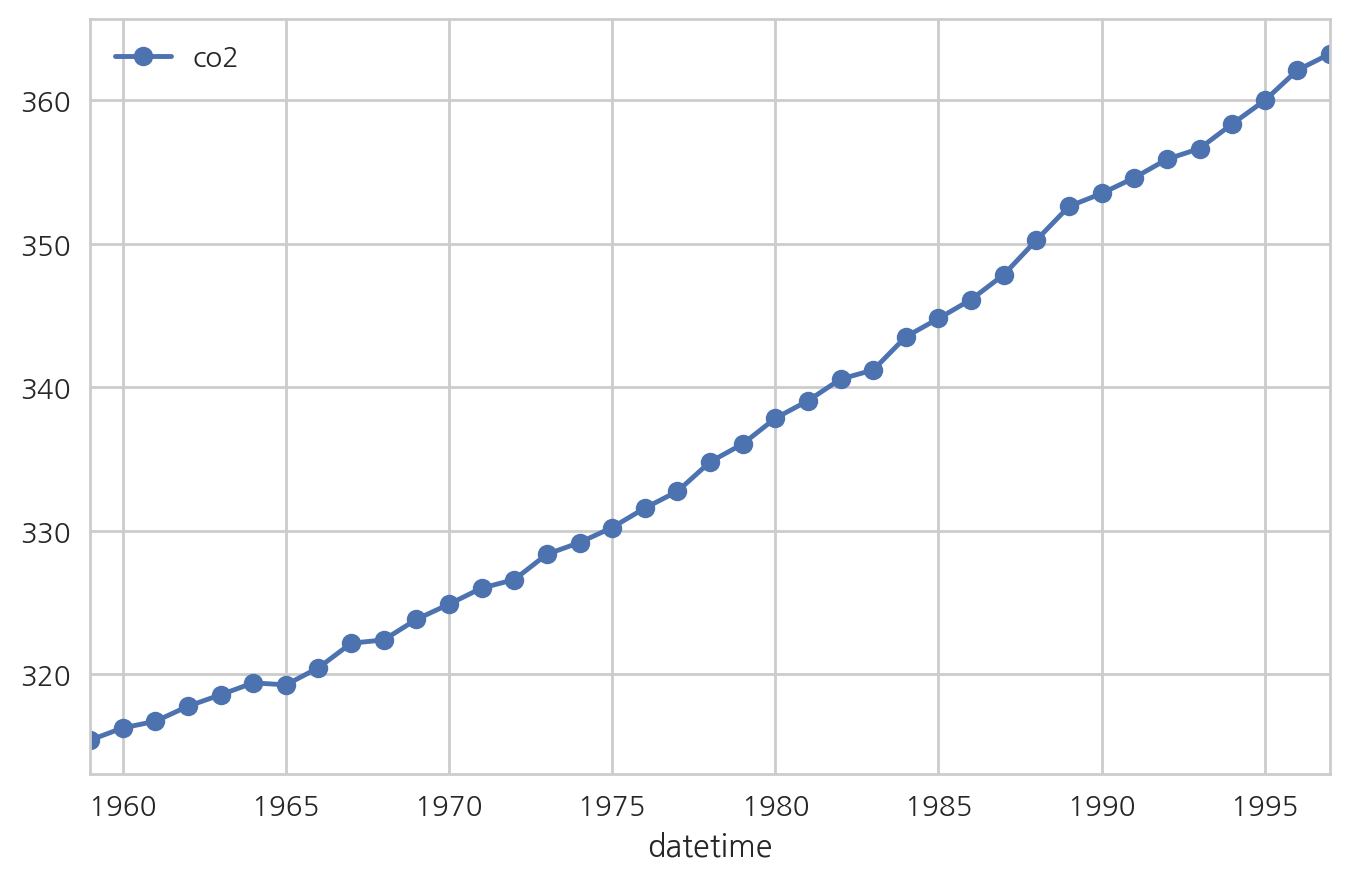

In [22]:
df[df.month == 1].plot(x="datetime", y="co2", marker='o')
plt.show()

이렇게 분리된 시계열을 ARIMA 모형으로 만들어 보자. 우선 12개월 단위로 차분을 하여 정상 신호로 만든다.

In [47]:
df["y2"] = df["co2"].diff(12)
df3 = df.iloc[12:, :]

In [52]:
df3[df3.month == 1].head(24)

,time,co2,datetime,y,month,y2
12,1960.0,316.27,1960-01-01,0.84,1,0.85
24,1961.0,316.73,1961-01-01,0.70,1,0.46
36,1962.0,317.78,1962-01-01,0.93,1,1.05
48,1963.0,318.58,1963-01-01,1.05,1,0.80
60,1964.0,319.41,1964-01-01,1.21,1,0.83
72,1965.0,319.27,1965-01-01,0.72,1,-0.14
84,1966.0,320.46,1966-01-01,1.21,1,1.19
96,1967.0,322.17,1967-01-01,1.30,1,1.71
108,1968.0,322.40,1968-01-01,0.60,1,0.23
120,1969.0,323.83,1969-01-01,1.09,1,1.43


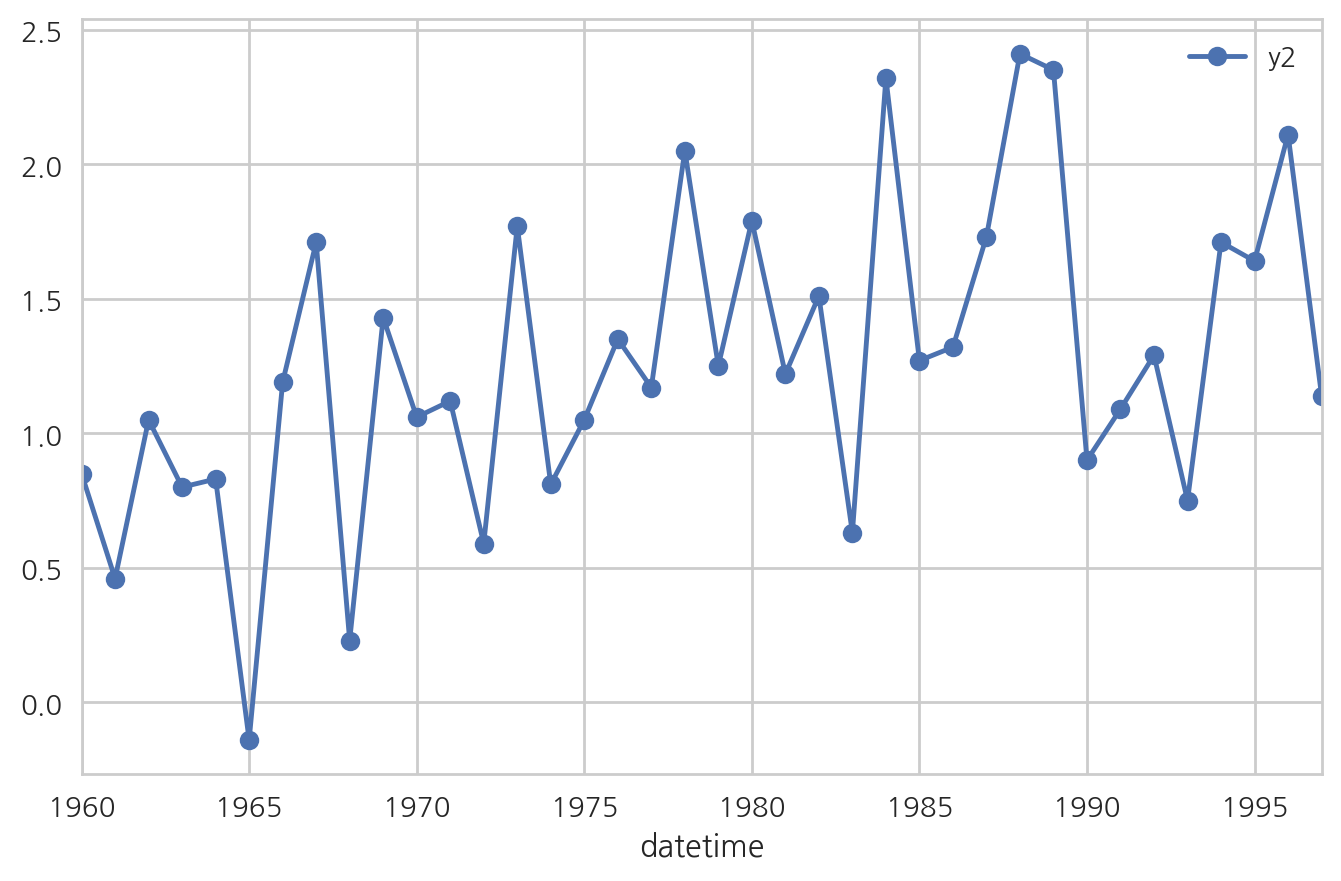

In [49]:
df3[df3.month == 1].plot(x="datetime", y="y2", marker='o')
plt.show()

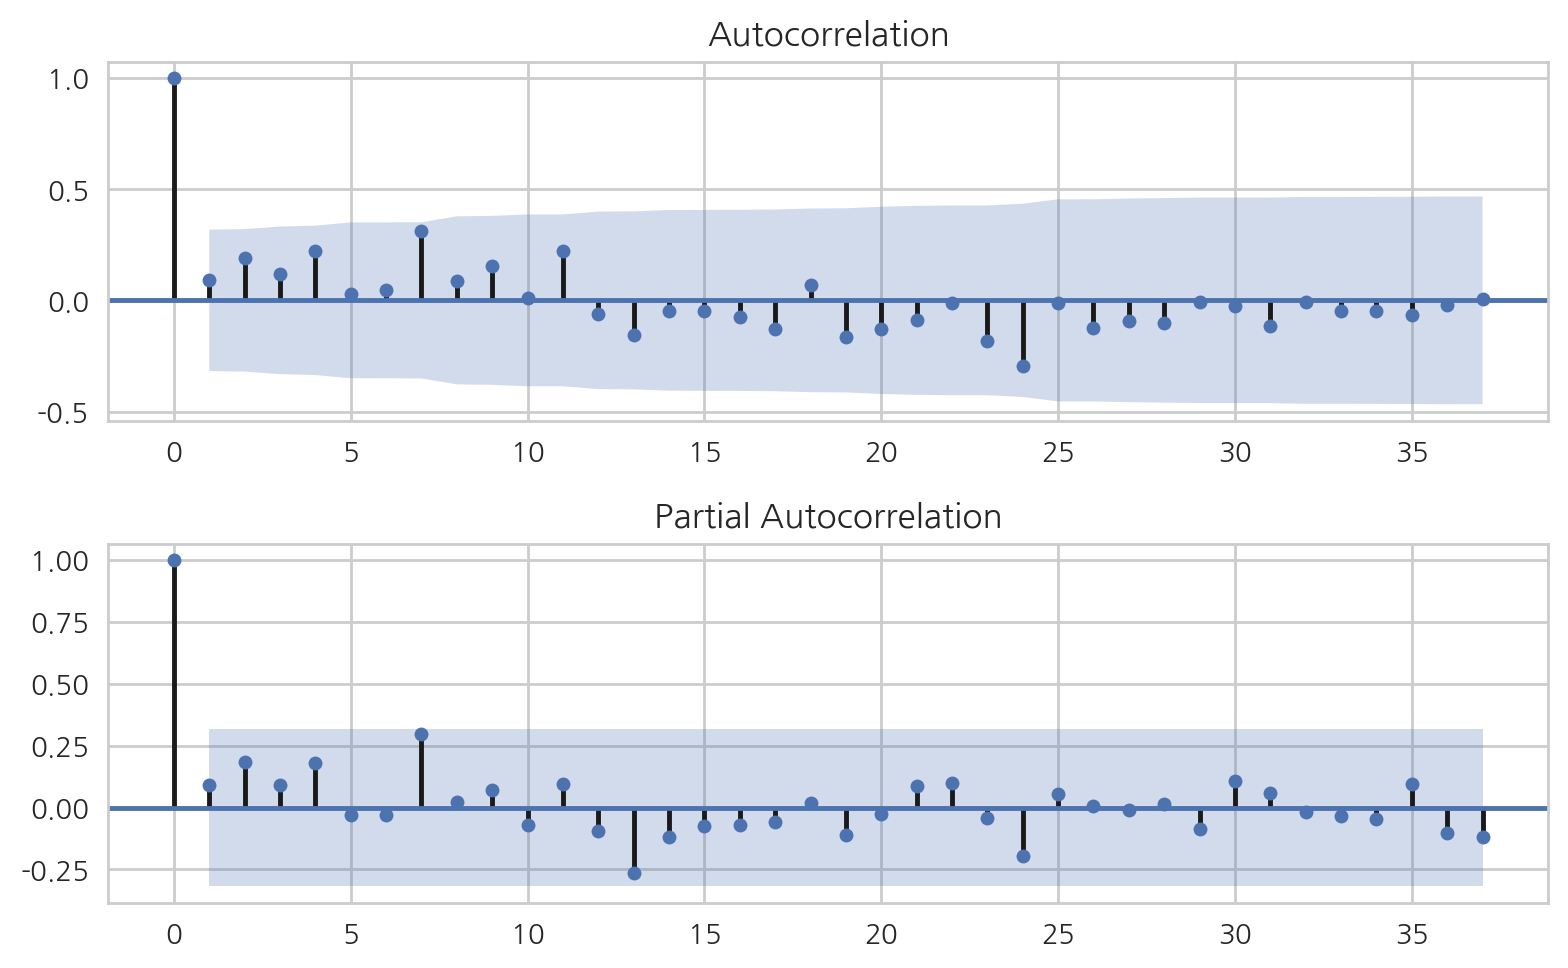

In [53]:
ax1 = plt.subplot(211); sm.graphics.tsa.plot_acf(df3[df3.month == 1]["y2"], ax=ax1)
ax2 = plt.subplot(212); sm.graphics.tsa.plot_pacf(df3[df3.month == 1]["y2"], ax=ax2)
plt.tight_layout()
plt.show()

이렇게 **각 계절별 시계열이 백색잡음이 아닌 일반적인 ARIMA 모형을 따르는**  모형을 **Seasonal ARIMA 모형**이라고 한다.

## 단순 Seasonal ARIMA 모형

Seasonal ARIMA 모형은 줄여서 SARIMA라고 하기도 한다. 단순 SARIMA 모형은 각 계절에 따른 독립적인 ARIMA 모형이 합쳐져 있는 모형이다. 기존 ARIMA(p,d,q) 모형에 계절성 주기를 나타내는 차수 s가 추가적으로 필요하기 때문에 SARIMA(P,D,Q,s) 로 표기한다.

s의 값은 월별 계절성을 나타낼 때는 $s=12$가 되고 분기별 계절성을 나타낼 때는 $s=4$가 된다.

### 단순 Seasonal MA 모형

예를 들어 각 월의 시계열 자료 값이 현재의 백색 잡음 이외에 작년 동월의 백색 잡음에도 영향을 받는다면 다음과 같은 단순 SARIMA(0,0,1,12) 모형이 된다. 

$$ Y_t = e_t - \Theta e_{t-12} $$

이 시계열은 시차(lag)가 12인 경우에는 자기상관계수가 0이 아니고 다른 경우에는 모두 0이된다. 즉, 다른 달끼리는 상관관계가 없다. 

$$ \text{Cov}[Y_t, Y_{t-1}] = \text{Cov}[ e_t - \Theta e_{t-12} ,  e_{t-1} - \Theta e_{t-13} ] = 0 $$

$$ \text{Cov}[Y_t, Y_{t-12}] = \text{Cov}[ e_t - \Theta e_{t-12} ,  e_{t-12} - \Theta e_{t-24} ] = -\Theta \sigma_e^2 $$

이 성질은 MA 차수 Q가 1이 아닌 일반적인 경우에도 성립한다. 예를 들어 다음과 같은 일반적인 단순 SARIMA(0,0,Q,s) 모형의 경우,
차수가 12인경우 (1년단위의 1월,2월별 데이터를 수집한 경우이다) 

$$ Y_t = e_t - \Theta e_{t-12} - \Theta e_{t-2\cdot 12} - \cdots - \Theta e_{t-Q \cdot 12} $$

자기상관계수의 값은 시차가 $ks$인 경우에만 0이 아닌 다음과 같은 값이 되고 다른 시차값에 대해서는 0이 된다.

$$ \rho_{ks} = \dfrac{-\Theta_k + \Theta_{1}\Theta_{k+1} + \Theta_{2}\Theta_{k+2} + \cdots + \Theta_{Q-k}\Theta_{k+Q}}{1 + \Theta_1^2 +\Theta_2^2 + \cdots + \Theta_Q^2} $$

### 단순 Seasonal AR 모형

예를 들어 각 월의 시계열 자료 값이 작년 동월의 자료값 자체에도 영향을 받는다면 다음과 같은 단순 SARIMA(1,0,0,12) 모형이 된다. 

$$ Y_t = \Phi Y_{t-12} + e_t  $$

이 확률 과정은 모수 $\Phi < 1$인 경우에만 정상 과정이 된다.

자기상관계수의 값은 시차가 $ks$인 경우에만 0이 아닌 다음과 같은 값이 되고 다른 시차값에 대해서는 0이 된다.

$$ \rho_{ks} = \Phi^k $$

## 일반적인 단순 Seasonal ARIMA 모형의 표기

ARMA(p,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$ Y_t = \phi_1 Y_{t-1} + \phi_2 Y_{t-2} + \cdots + \phi_p Y_{t-p} + e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

$$ Y_t - \phi_1 Y_{t-1} - \phi_2 Y_{t-2} - \cdots - \phi_p Y_{t-p} = e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

이를 시간 지연 연산자 $L$을 사용하면 다음과 같이 표기하기도 한다.

L로 묶인 하나의 함수로 변경가능하다 

$$ \phi(L)Y_t = \theta(L)e_t $$

여기에서 $\phi(L)$과 $\theta(L)$은 다음과 같은 다항식을 표시한다.

$$ \phi(L) = 1 - \phi_1 L - \phi_2 L^2 - \cdots - \phi_p L^p  $$

$$ \theta(L) = 1 - \theta_1 L - \theta_2 L^2 - \cdots - \theta_q L^q  $$

이 다항식은 원래의 모형 수식을 다음과 같이 간결하게 나타내기 위한 것이다.

$$ 
\begin{eqnarray}
Y_t - \phi_1 Y_{t-1} - \phi_2 Y_{t-2} - \cdots - \phi_p Y_{t-p} 
&=& Y_t - \phi_1 LY_t - \phi_2 L^2Y_t - \cdots - \phi_p L^pY_t \\
&=& (1 - \phi_1 L - \phi_2 L^2 - \cdots - \phi_p L^p)Y_t \\
&=& \phi(L)Y_t \\
\end{eqnarray}
$$

일반적인 단순 Seasonal ARIMA (P,0,Q,S) 모형은 모든 시간 지연이 s의 배수이기 때문에 다음과 같이 표기한다.

$$ \phi(L^s)Y_t = \theta(L^s)e_t $$

이를 풀면 다음과 같은 의미이다.

$$ Y_t = \phi_1 Y_{t-s} + \phi_2 Y_{t-2s} + \cdots + \phi_P Y_{t-Ps} + e_t - \theta_1 e_{t-s}  - \theta_2 e_{t-2s} - \cdots  - \theta_Q e_{t-Qs} $$

ARIMA(p,1,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$ Y_t-Y_{t-1} - \phi_1 (Y_{t-1}-Y_{t-2}) - \phi_2 (Y_{t-2}-Y_{t-3}) - \cdots - \phi_p (Y_{t-p}-Y_{t-p-1}) = e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

$$ \nabla Y_t - \phi_1 \nabla Y_{t-1} - \phi_2 \nabla Y_{t-2} - \cdots - \phi_p \nabla Y_{t-p} = e_t - \theta_1 e_{t-1}  - \theta_2 e_{t-2} - \cdots  - \theta_q e_{t-q} $$

$$ \phi(L)\nabla Y_t = \theta(L)e_t $$

ARIMA(p,d,q) 모형은 다음과 같이 수식으로 나타낼 수 있다.

$$ \phi(L)\nabla^d Y_t = \theta(L)e_t $$

이 식에서 $\nabla^d$는 $d$번 차분하는 연산을 의미한다.

단순 Seasonal ARIMA (P,1,Q,S) 모형은 다음과 같이 쓸 수 있다.

$$ \phi(L^s)\nabla_s Y_t = \theta(L^s)e_t $$

이 식에서 $\nabla_s$는 $s$-시간 지연 차분을 나타낸다. 즉 $\nabla_s Y_t = Y_t - Y_{t-s}$이다. 이 식을 풀면 다음과 같은 의미이다.

$$ Y_t-Y_{t-s} - \phi_1 (Y_{t-s}-Y_{t-2s}) - \phi_2 (Y_{t-2s}-Y_{t-3s}) - \cdots - \phi_P (Y_{t-Ps}-Y_{t-(P-1)s}) = e_t - \theta_1 e_{t-s}  - \theta_2 e_{t-2s} - \cdots  - \theta_Q e_{t-Qs} $$

단순 Seasonal ARIMA (P,D,Q,S) 모형은 다음과 같이 쓸 수 있다.

$$ \phi(L^s)\nabla_s^D Y_t = \theta(L^s)e_t $$

이 식에서 $\nabla_s^d$는 $s$-시간 지연 차분을 $D$번 반복하는 연산을 의미한다.